# Predicting Bike Rental Counts
Our goal in this project is to predict the hour-by-hour count of bike rentals, using a dataset of statistics for the bike rental system of Washington, DC.

In the following:
- We will look at the data, then choose useful prediction features. 
- We will use different algorithms (Linear Regression and Random Forest) and compare their performance.

In [1]:
# Import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load and visualise data
bike_rentals = pd.read_csv("bike_rental_hour.csv")
data = bike_rentals.copy()
print(data.shape)
data.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Text(0.5,1,'Hourly bike rentals')

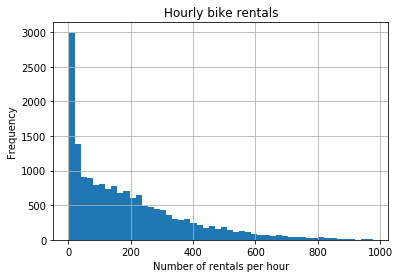

In [3]:
fig, ax = plt.subplots()
data["cnt"].hist(ax=ax,bins=50)
ax.set_xlabel("Number of rentals per hour")
ax.set_ylabel("Frequency")
ax.set_title("Hourly bike rentals")

In [4]:
data["cnt"].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

On average, the mean number of rentals per hour is 189 and the median number is 142. Larger numbers of rentals per hour are not uncommon, with the maximum number of bike rentals in a single hour recorded as 977.

## Dataset preparation
The question we want to answer is: can we use current (hourly) parameters to predict the likely number of bike rentals in the *next* hour? For example, this could be useful for the management of the rental system to dynamically allocate resources as they are needed.

To do so, we must manipulate the dataset i.e. shift the "count" column up by one so that the number of bike rentals is stored next to the parameters of the previous hour. We'll lose one datapoint, but we have 17378 more to work with!

In [5]:
data_bkp = data.copy()
data1 = data.iloc[:-1,:-1].copy().reset_index(drop=True)
data2 = data.iloc[1:,-1].copy().reset_index(drop=True)
data = pd.concat([data1,data2],axis=1)
print(data.shape)
data.head()

(17378, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,40
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,32
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,13
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


There are a few categorical columns which should be expanded using dummy columns so that the models can deal with them properly. Before doing so, let's look at a few of them.

In [6]:
data["weathersit"].value_counts()

1    11412
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

Category 4 of 'weathersit' is almost unrepresented: once we expand this into dummy_columns the corresponding column should be dropped.

Let's look at 'yr'.

In [7]:
data["yr"].value_counts()

1    8733
0    8645
Name: yr, dtype: int64

There are only two possible values, therefore the two resulting dummy columns will be mutually exclusive and redundant. We'll drop one of the two.

Beyond these considerations, there's an opportunity for dropping either the 'mnth' or the 'season' column since they convey much of the same information. We might also want to group the 'hr' column into fewer groups (e.g. 3-hrs groups). 

In [8]:
# Drop the month column since we already have a season one
data = data.drop("mnth",axis=1)
# Group the hours into fewer categories and drop the original column
cut_points = [-.5,2.5,5.5,8.5,11.5,14.5,17.5,20.5,23.5]
label_names = ["late_night","early_morning","morning","late_morning","afternoon","early_evening","late_evening","night"]
data["grp_hr"] = pd.cut(data["hr"],cut_points,labels=label_names)
data = data.drop("hr",axis=1)

All remaining categorical columns can now be expanded into dummy columns.

In [9]:
expand = ["season","grp_hr","weekday","weathersit","yr"]
for e in expand:
    dummies = pd.get_dummies(data[e],prefix=e)
    data = pd.concat([data,dummies],axis=1)
    data = data.drop(e, axis=1)
# Drop the category 4 weather column and the category 1 year column
data = data.drop(["weathersit_4","yr_1"],axis=1)

## Feature selection
The next step involves choosing the best features.

The "registered" and "casual" columns can be ignored; the "cnt" values are directly derived from their summation, and after reshaping the data they're out of sync too.

Further columns that can be safely removed are the date of rental ("dteday"), the ID number for the row ("instant"). The two temperature columns are redundant, so we can drop one of the two.

In [10]:
remove = ["cnt","casual","registered","dteday","atemp","instant"]
features = list(data.columns)
for r in remove:
    features.remove(r)
target = "cnt"

Let's split the dataset into a training and test datasets (80%-20%) split.

In [11]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(data[features], data[target], test_size=.2, random_state=1)

Now we can use the sklearn.feature_selection.RFECV() method to select the best features for our model. 

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

In [13]:
rf = RandomForestRegressor()
selector = RFECV(rf,cv=10)
selector.fit(xtrain,ytrain)
optm_features = xtrain.columns[selector.support_]
optm_features

Index(['workingday', 'temp', 'hum', 'windspeed', 'season_1', 'season_2',
       'season_4', 'grp_hr_late_night', 'grp_hr_early_morning',
       'grp_hr_morning', 'grp_hr_late_morning', 'grp_hr_afternoon',
       'grp_hr_early_evening', 'grp_hr_late_evening', 'grp_hr_night',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'yr_0'],
      dtype='object')

## Linear regression
The first model we will test is a simple linear regression model.

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [15]:
lr = LinearRegression()
lr.fit(xtrain[optm_features],ytrain)
predictions = lr.predict(xtest[optm_features])
mse = mean_squared_error(ytest,predictions)
rmse = np.sqrt(mse)
rmse

110.47098394961782

In [16]:
(rmse/ytest).mean()

4.8319280091351215

The RMSE is on average 4.83 times the daily count of rented bikes - really quite high. Can this be improved using other models?

## Random Forest
The second model we will test is an ensemble method, i.e. a Random Forest Regressor algorithm. We can use GridSearchCV to find the best hyperparameters.

In [17]:
from sklearn.model_selection import GridSearchCV

In [20]:
hyperparameters = {
    "max_depth": range(1,20,2),
    "max_features": ["log2","sqrt","auto"],
    "min_samples_leaf": [1,5],
    "min_samples_split": [3,5],
    "n_estimators": [6,9]
}

In [22]:
rf = RandomForestRegressor(random_state=1)
grid = GridSearchCV(rf, param_grid=hyperparameters, cv = 10)
grid.fit(xtrain[optm_features],ytrain)
best_params = grid.best_params_
best_score = grid.best_score_
print("Best Parameters: ",best_params,"\nScore: ",best_score)
best_rf = grid.best_estimator_

Best Parameters:  {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 9} 
Score:  0.8155480053751627


In [23]:
predictions = best_rf.predict(xtest[optm_features])
mse = mean_squared_error(ytest,predictions)
rmse = np.sqrt(mse)
rmse

76.96667244543659

In [24]:
(rmse/ytest).mean()

3.366471511909792